# Notebook to run the edges2grayscale GAN
##### Written by Badr Belhiti
Loads in a trained model from the specified file and propagates forward to generate images. The generated images are visualized using this notebook.

In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder

### Initialize device

In [2]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Parameters for loading model, defining architecture, and forward propagation

In [3]:
# Path to the .pth file
model_dir = '../models/'
model_path = model_dir + 'second_stage.pth'

# Directory for edge images input
edges_dir = '../data/baseline_samples/new/'

# Number of workers for dataloader
workers = 2

# Number of channels in the training images. 3 for color images and 1 for grayscale images.
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Images to display at once
batch = 64

# Number of samples to display
samples = batch

# Constant noise vector. This is fine since we only do one forward pass of the network in this notebook.
fixed_noise = torch.randn(samples, nz, 1, 1, device=device)

### Define model architecture

In [4]:
# ResNet-6 image-to-image implementation
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Initial convolutional layer that preserves resolution and creates 'ngf' output channels
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(nc, ngf, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]

        # Down sampling layers that take input from 128x128 to 32x32 while progressively adding channels
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(
                    ngf * mult,
                    ngf * mult * 2,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True),
            ]

        # Propagate signal through 6 ResNet blocks, preserving height and width
        mult = 2 ** n_downsampling
        for i in range(6):

            model += [ResnetBlock(ngf * mult)]

        # Upsample signal back to 128x128
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(
                    ngf * mult,
                    int(ngf * mult / 2),
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=True,
                ),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True),
            ]

        # Preserve height and width while decreasing channel depth to 1
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


# ResNet block that uses reflection padding and instance normalization
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    # An arbitrary convolutional block that maintains dimensionality
    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
        ]

        return nn.Sequential(*conv_block)

    # ResNet architecture relies on "skip-connections" to achieve superior results
    def forward(self, x):
        return x + self.conv_block(x)

### Load conditional input

In [5]:
transform = transforms.Compose([    
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = ImageFolder(root=edges_dir, transform=transform)
dataloader = DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=workers)

### Load generator from trained 'model.pth'

In [6]:
model = Generator()
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### Load in batch once

In [7]:
inputs = next(iter(dataloader))

### Visualize generated images

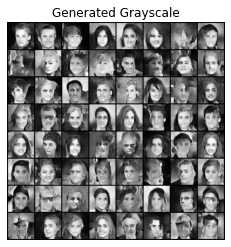

In [8]:
with torch.no_grad():
    tensor = inputs[0][:samples]
    input_imgs = np.transpose(vutils.make_grid(tensor, padding = 5, normalize=True), (1, 2, 0))
    fake_image = model(tensor).to(device)
    output_imgs = np.transpose(vutils.make_grid(fake_image, padding = 5, normalize=True), (1, 2, 0))
    plt.title('Generated Grayscale')
    plt.axis('off')
    plt.imshow(output_imgs, cmap='gray')